In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import os
import tensorflow as tf
from sklearn import metrics
from sklearn.utils import shuffle
from keras.preprocessing import text 
from collections import OrderedDict
import re
import math
import pickle
import time
import sys
import gc
# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


## Loaded dataset

In [2]:
def getTrainHoldoutSplit(df, dfLabel, holdoutSize=0.20):
    from sklearn import model_selection 
    dfHoldOut = None
    dfHoldOutLabel = None

    cv_pre = model_selection.StratifiedShuffleSplit(n_splits=1, test_size=holdoutSize, random_state=1)
    for train_index, test_index in cv_pre.split(df, dfLabel):
        y_train, y_test = dfLabel[train_index], dfLabel[test_index]
        x_train, x_test = df.iloc[train_index], df.iloc[test_index]
        df, dfLabel = x_train, y_train
        dfHoldOut, dfHoldOutLabel = x_test, y_test

    print("==================== Data Set ==================================")
    print("Holdout Set => ", dfHoldOut.shape)
    print("Train Set => ", df.shape)
    print("==================== Data Set ==================================")
    return df, dfLabel, dfHoldOut, dfHoldOutLabel

In [3]:
# df = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/train.csv', nrows=10000)
# dfTest = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/test.csv', nrows=1000)
df = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/train.csv')
dfTest = pd.read_csv('../input/jigsaw-unintended-bias-in-toxicity-classification/test.csv')

df['pred'] = df['target'].apply(lambda x: 1 if x >= 0.5 else 0)

# df = pd.read_csv("../input/fake-news-detection/data.csv")
# df = df.fillna('')
# df['comment_text'] = df['Headline']
# df['pred'] = df['Label']
# df['id'] = df.index
# dfTest = df

def filter_initial_sentence(x):
    return " ".join([re.sub('[^a-z0-9 ]+', '', x) if re.sub('[^a-z0-9 ]+', '', x) else x for x in x.lower().split()])

def tokenize_initial_sentence(x):
    x = re.sub("[’‘'“\"”.\n\t\r]+", '', x.lower())
    pat = re.compile(r"([—!#$%&()*+,-./:;<=>?@\[\\\]^_`{|}~\t\n…])")
    x = re.sub("[0-9]+", '', x.lower())
    return pat.sub(" \\1 ", x)

df['comment_text'] = df['comment_text'].apply(tokenize_initial_sentence)
dfTest['comment_text'] = dfTest['comment_text'].apply(tokenize_initial_sentence)

df, dfLabel, dfHoldOut, dfHoldOutLabel = getTrainHoldoutSplit(df, df['pred'], holdoutSize=0.15)
df, dfLabel, dfVal, dfValLabel = getTrainHoldoutSplit(df, df['pred'], holdoutSize=0.18)

# Check Positive vs Negative samples
print("==========Train Sample Distribution =============")
print(dfLabel.value_counts())
print("==========Validation Sample Distribution ===========")
print(dfValLabel.value_counts())
print("==========Holdout Sample Distribution ===========")
print(dfHoldOutLabel.value_counts())
print("=================================================")

==================== Data Set ==================================
Holdout Set =>  (270732, 46)
Train Set =>  (1534142, 46)
==================== Data Set ==================================


/opt/conda/lib/python3.6/site-packages/pandas/core/series.py:842: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


==================== Data Set ==================================
Holdout Set =>  (276146, 46)
Train Set =>  (1257996, 46)
==================== Data Set ==================================
==========Train Sample Distribution =============
0.0    985215
1.0     84356
Name: pred, dtype: int64
==========Validation Sample Distribution ===========
0.0    216204
1.0     18296
Name: pred, dtype: int64
==========Holdout Sample Distribution ===========
0    249082
1     21650
Name: pred, dtype: int64


### Tokenizer Keras used for tokenization and unique  word count

In [4]:
from nltk.tokenize.treebank import TreebankWordTokenizer
tokenizer = TreebankWordTokenizer()
max_features = 2000000
# tokenizer.fit_on_texts(df['comment_text'].tolist())
tokenizer = text.Tokenizer(num_words = max_features, filters="", lower=True, split=" ")
tokenizer.fit_on_texts(df['comment_text'].tolist() + dfHoldOut['comment_text'].tolist() + dfTest['comment_text'].tolist())

print(len(tokenizer.word_index))
tokenize_dict = tokenizer.word_index

713144


## Embedding Loadup

In [5]:
def load_embeddings_partial(embedings_filepath, tokenize_dict, embedding_size=300):
    def load_embeddings_vec(path):
        def nop(it, *a, **k):
            return it

        def get_coefs(word, *arr):
            return word, np.asarray(arr, dtype='float32')

        tqdm = nop
        with open(path) as f:
            return dict(get_coefs(*line.strip().split(' ')) for line in tqdm(f))

    def load_embeddings_pkl(path):
        with open(path,'rb') as f:
            emb_arr = pickle.load(f)
        return emb_arr
    print("Loading file", embedings_filepath)
    if embedings_filepath.endswith("pkl"):
        embedding_index_ = load_embeddings_pkl(embedings_filepath)
    else:
        embedding_index_ = load_embeddings_vec(embedings_filepath)
    print("Loaded")

    embedding_index = {}
    for key, value in embedding_index_.items():
        embedding_index[key.lower()] = value
    del embedding_index_

    print(len(embedding_index))
    embeddings = np.zeros((len(tokenize_dict) + 1, embedding_size))
    unknown_words = []

    tokens = list(tokenize_dict.keys())
    found = 0
    lookup_index = OrderedDict()
    for i in range(len(tokens)):
        try:
            word = tokens[i]
            lookup_index[word] = i
            embeddings[i] = embedding_index[word]
            found += 1
        except Exception as err:
            unknown_words.append(word)

    del embedding_index
    print("lookup_index:", len(list(lookup_index.keys())))
    
    print("Total Words:", len(tokenize_dict), "Total Unknow Words:", len(unknown_words), "Total Found:", found)
    print("Embeddings shape:", embeddings.shape)

    """ Dictionary which gives index of word in embeddings,
    Eg. lookup_index['word'] will return integer value, and at that index location in embeddings we can find its vector """
    lookup_index_tf = tf.constant(list(lookup_index.keys()))
    table = tf.contrib.lookup.index_table_from_tensor(mapping=lookup_index_tf, default_value=lookup_index["-"])
    gc.collect()
    return embeddings, table, unknown_words

embedding_filepath = "../input/pickled-crawl300d2m-for-kernel-competitions/crawl-300d-2M.pkl"
embedding_filepath = "../input/pickled-glove840b300d-for-10sec-loading/glove.840B.300d.pkl"
embedding_filepath = "../input/vector-jigsaw/jigsaw.pkl"
# embedding_filepath = "../input/crawl300d2m/crawl-300d-2M.vec"
# embedding_filepath = "../input/glove-840b-300d/glove.840B.300d.txt"

embeddings, table, unknown_words = load_embeddings_partial(embedding_filepath, tokenize_dict,
                                                           embedding_size=150)
embeddings_tf = tf.placeholder(tf.float32, embeddings.shape, name='embeddings_tf')

print(embeddings.shape)
print(unknown_words[0:100])
gc.collect()

Loading file ../input/vector-jigsaw/jigsaw.pkl
Loaded
792179
lookup_index: 713144
Total Words: 713144 Total Unknow Words: 2132 Total Found: 711012
Embeddings shape: (713145, 150)

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use tf.cast instead.
(713145, 150)
['cannot', 'gonna', 'gotta', 'wanna', 'gimme', '\xa0', 'lemme', '\xa0the', '\u2004\u2004\u2004usa', '\u2009', '\xa0and', '\xa0million', '\xa0a', '\u2009\u2009', '\xa0http', '\u200aand', '\xa0if', '\xa0that', '\u2002', '\u2028', 'of\xa0the', '✨\u2005\u2005', 'repatriate»', 'for\xa0the', '\xa0\xa0', 'tombeau»', '☭\u2004', 'growth\u2028', '\xa0people', '«sir', '»«', '\u2009trillion', '»i', '\xa0of', '\xa0\xa0\xa0\xa0\xa0', '\xa0is', 'that\xa0there', '»theres', '\xa0billion', 'a\xa0', '\u2028\u2028•', 'c\u2009', 'presiden

0

### Model Creation

In [6]:
n_x  = 150
n_y = 2
n_t = 200
result_at_mod = 50

In [7]:
# tf.reset_default_graph()
results = {}
G = tf.Graph()
print(G)
with G.as_default():
    counter = tf.Variable(0, name='counter', trainable=False)
    assert counter.graph is G

    xav_init = tf.contrib.layers.xavier_initializer
    keep_prob = tf.placeholder(dtype=tf.float32, name='keep_prob')
    learning_rate = tf.placeholder(dtype=tf.float32, name='learning_rate')
    x = tf.placeholder(shape=[None, n_t, n_x], dtype=tf.float32, name='x')
    y = tf.placeholder(shape=[None], dtype=tf.int32, name='y')
    class_weights = tf.placeholder(shape=[1, 2], dtype=tf.float32)
    print("x:", x.shape)
    yt = tf.reshape(y, [-1])  # check this print yt and yb
    
    input_ = tf.cast(x, tf.float32)
    print(input_.shape)
    with tf.variable_scope("conv1") as scope:
        net = tf.contrib.layers.conv1d(input_, 64, 5, activation_fn=tf.nn.leaky_relu, padding='SAME',
            weights_initializer=xav_init(),scope=scope,reuse=False)
        net = tf.layers.max_pooling1d(net, pool_size=3, strides=2, padding='SAME')
        print("CONV1", net.shape)

    with tf.variable_scope("conv2") as scope:
        net = tf.contrib.layers.conv1d(net, 128, 5, activation_fn=tf.nn.leaky_relu, padding='SAME',
            weights_initializer=xav_init(), scope=scope,reuse=False)
        net = tf.layers.max_pooling1d(net, pool_size=3, strides=2, padding='SAME')
        print("CONV2", net.shape)

    with tf.variable_scope("conv3") as scope:
        net = tf.contrib.layers.conv1d(net, 256, 5, activation_fn=tf.nn.leaky_relu, padding='SAME',
            weights_initializer=xav_init(), scope=scope,reuse=False)
        net = tf.layers.max_pooling1d(net, pool_size=3, strides=2, padding='SAME')
        print("CONV3", net.shape)

    with tf.variable_scope("conv4") as scope:
        net = tf.contrib.layers.conv1d(net, 512, 5, activation_fn=tf.nn.leaky_relu, padding='SAME',
            weights_initializer=xav_init(), scope=scope,reuse=False)
        net = tf.layers.max_pooling1d(net, pool_size=3, strides=2, padding='SAME')
        print("CONV4", net.shape)
    flatten = tf.contrib.layers.flatten(net)
    print("FLATTEN", flatten.shape)

    with tf.variable_scope("dnn1") as scope:
        dense = tf.layers.dense(inputs=flatten, units=1024, kernel_initializer=xav_init(),
                                activation=tf.nn.leaky_relu)
        dense = tf.nn.dropout(dense, keep_prob=keep_prob)
        print("Dense1", dense.shape)

    with tf.variable_scope("dnn2") as scope:
        dense = tf.layers.dense(inputs=dense, units=512, kernel_initializer=xav_init(), 
                            activation=tf.nn.leaky_relu)
        print("Dense2", dense.shape)

    logits = tf.layers.dense(inputs=dense,kernel_initializer=xav_init(), 
                             activation=tf.nn.leaky_relu, units=2)

    logits = tf.layers.dense(inputs=dense,kernel_initializer=xav_init(), 
                             activation=tf.nn.leaky_relu, units=2)

    print("logits:", logits)

    predictions_softmax = tf.nn.softmax(logits)
    predictions_argmax  =  tf.argmax(predictions_softmax, axis=1)

    train_vars   = tf.trainable_variables() 
    l2_loss = tf.add_n([ tf.nn.l2_loss(v) for v in train_vars if 'bias' not in v.name ]) * 0.001
    l2_loss_mean = tf.reduce_mean(l2_loss)

    
    yt_onehot = tf.one_hot(yt, n_y)
    
    weight_per_label = tf.linalg.matmul(tf.to_float(yt_onehot), tf.transpose(class_weights)) # shape [batch_size, 2]
    loss_all = tf.math.multiply(weight_per_label, tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=yt))

    loss_all_mean = tf.reduce_mean(loss_all)

    #     loss_train = loss_all + 0.5 * (1 - f1)    
    loss_train = loss_all + l2_loss_mean * 0.005
    loss = tf.reduce_mean(loss_train)

    tf.summary.scalar('loss_modified', loss)
    tf.summary.scalar('loss', tf.reduce_mean(loss_all))

    #     optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    #     tvars = tf.trainable_variables()
    #     grads, _ = tf.clip_by_global_norm(tf.gradients(loss_all, tvars), 10)
    #     train_op = optimizer.apply_gradients(zip(grads, tvars))

    train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss_train)
    global_step = tf.assign_add(counter, 1, name='global_step')

    cls_sess = tf.Session()
    init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
    cls_sess.run(init_op)

    #     total_parameters = np.sum([np.prod(v.shape) for v in tf.trainable_variables()])
    #     print(total_parameters)
    print(loss.graph)

Instructions for updating:
Colocations handled automatically by placer.
x: (?, 200, 150)
(?, 200, 150)
Instructions for updating:
Use keras.layers.max_pooling1d instead.
CONV1 (?, 100, 64)
CONV2 (?, 50, 128)
CONV3 (?, 25, 256)
CONV4 (?, 13, 512)
Instructions for updating:
Use keras.layers.flatten instead.
FLATTEN (?, 6656)
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Dense1 (?, 1024)
Dense2 (?, 512)
logits: Tensor("dense_1/LeakyRelu:0", shape=(?, 2), dtype=float32)
Instructions for updating:
Use tf.cast instead.


In [8]:
def parse_function(row):
        row = table.lookup(row)
        output = tf.nn.embedding_lookup(embeddings_tf, row)
        """ See how can we add below features that were their in the original
        pos_tag(sent)
        getWordFeatures(token)
        """
        return output
    
def getDatasetIterator(ids, texts, labels, mode="TRAIN", batchsize=2, dimentions=100):
    def truncate(x):
        dim = tf.size(x)
        return tf.cond(tf.equal(dim, n_t), 
            lambda: x, lambda: tf.cond(tf.greater(dim, n_t),
            lambda: tf.slice(x, [0], [n_t]), 
            lambda: x, 0))

    sentences = tf.data.Dataset.from_tensor_slices(texts)
    sentences = sentences.map(lambda string: tf.string_split([string]).values)
    sentences = sentences.map(truncate)
    #sentences = sentences.map(parse_function, num_parallel_calls=4)
    sentences_embed = sentences.map(parse_function)
    if mode in ['TRAIN', 'EVAL']:
        ids =  tf.data.Dataset.from_tensor_slices(ids)
        labels = tf.data.Dataset.from_tensor_slices(labels)
        dataset = tf.data.Dataset.zip((ids, sentences_embed, labels))
        if mode == "TRAIN":
            dataset = dataset.shuffle(buffer_size=batchsize*2)
        dataset = dataset.padded_batch(batchsize, padded_shapes=([], [n_t, dimentions], []),
                                       drop_remainder=True)
    elif mode in ['PREDICT']:
        ids =  tf.data.Dataset.from_tensor_slices(ids)
        dataset = tf.data.Dataset.zip((ids, sentences_embed))        
        dataset = dataset.padded_batch(batchsize, padded_shapes=([], [n_t, dimentions]))
    dataset = dataset.prefetch(1)
    iterator = dataset.make_initializable_iterator()
    next_element = iterator.get_next()
    init_op = iterator.initializer
    return init_op, next_element

def execute(df, batchsize=4, mode="TRAIN", max_timestamps=200, comment=""):
    df['comment_text'] = df['comment_text'].apply(lambda x: x.replace("\n", ''))

    init_op_model, next_element_model = getDatasetIterator(df['id'], df['comment_text'], df['pred'] if mode in ['TRAIN', 'EVAL'] else None, 
                                                           mode=mode, batchsize=batchsize, dimentions=n_x)

    sess = tf.Session()
    sess.run(tf.tables_initializer())

    print("Iterations:", int(math.ceil(df.shape[0] / batchsize)))
    sess.run(init_op_model, feed_dict={embeddings_tf: embeddings})

    eval_loss = []
    train_loss = []
    y_true_all = []
    y_pred_all = []
    predictions = []

    while True:
        st = time.time()
        try:
            batch = sess.run(next_element_model)
            ids = batch[0]
            xb = batch[1]
            if mode in ['TRAIN', 'EVAL']:
                yb = batch[2].astype(np.int)

            if xb.shape[1] > max_timestamps:
                xb = xb[:, 0:max_timestamps, :]

            if mode == "TRAIN":
                ratio = (np.sum(yb) + 0.0001) / np.size(yb) 
                result = cls_sess.run([train_op, global_step, loss, predictions_argmax, yt],
                                       feed_dict = {
                                                x: xb, y: yb, keep_prob: 0.85, learning_rate: 0.002,
                                                class_weights: [[ratio, 1.0 - ratio]],
                                        })
                global_step_, loss_, y_pred, y_true = result[1:5]
                train_loss.append(loss_)
                y_true_all.extend(y_true)
                y_pred_all.extend(y_pred)
                total_elem = df.shape[0]
                total_processed = len(y_pred_all)
                complete_percent = int((total_processed / total_elem) * 100 )

                if complete_percent < 3 or complete_percent > 98 or complete_percent % result_at_mod == 0 :
                    cmd = ["####", comment, "Progress", str(complete_percent), 
                           "Loss(avg):", str(round(np.mean(train_loss), 2)), 
                           "P:", str(round(metrics.precision_score(y_true_all, y_pred_all), 2)),
                           "R:", str(round(metrics.recall_score(y_true_all, y_pred_all), 2)),
                           "F1:", str(round(metrics.f1_score(y_true_all, y_pred_all), 2)),
                           "Acc:", str(round(metrics.accuracy_score(y_true_all, y_pred_all), 2)),
                           'Time:', str(round(time.time() - st, 2))]
                    cmd = " ".join(cmd)
                    sys.stderr.write('\r\033[2K %s' % (cmd))
                    sys.stderr.flush()

                results[global_step_] = {
                                        'P': round(metrics.precision_score(y_true, y_pred), 2),
                                        'R': round(metrics.recall_score(y_true, y_pred), 2),
                                        'F1': round(metrics.f1_score(y_true, y_pred), 2),
                                        'ACC': round(metrics.accuracy_score(y_true, y_pred), 2),
                                        'Loss': round(loss_, 3)
                }

            elif mode == "EVAL":
                ratio = (np.sum(yb) + 0.0001) / np.size(yb) 
                result = cls_sess.run([loss, predictions_argmax, yt],
                                       feed_dict = { 
                                                x: xb, y: yb, keep_prob: 1.0,
                                                class_weights: [[ratio, 1.0 - ratio]]
                                       })

                loss_, y_pred, y_true = result[0: 3]
#                     print(y_true, y_pred)
#                     print(result[-2])
                eval_loss.append(loss_)
                y_true_all.extend(y_true)
                y_pred_all.extend(y_pred)

                total_elem = df.shape[0]
                total_processed = len(y_pred_all)
                complete_percent = int((total_processed / total_elem) * 100 )
                if complete_percent < 3 or complete_percent > 98 or complete_percent % result_at_mod == 0 :
                    cmd = ["####", comment, "Progress ", str(complete_percent), "Loss(avg):", str(round(np.mean(eval_loss), 2)), 
                           "P:", str(round(metrics.precision_score(y_true_all, y_pred_all), 2)),
                          "R:", str(round(metrics.recall_score(y_true_all, y_pred_all), 2)),
                          "F1:", str(round(metrics.f1_score(y_true_all, y_pred_all), 2)),
                          "Acc:", str(round(metrics.accuracy_score(y_true_all, y_pred_all), 2)),
                          'Time:', str(round(time.time() - st, 2))]
                    cmd = " ".join(cmd)
                    sys.stderr.write('\r\033[2K %s' % (cmd))
                    sys.stderr.flush()
            elif mode == "PREDICT":
                result = cls_sess.run([predictions_softmax], feed_dict = { x: xb, keep_prob: 1.0 })
                prediction = result[0]
                prediction = list(zip(ids, prediction[:, 1]))
                predictions.extend(prediction)
            
            del xb
            del ids
            
        except tf.errors.OutOfRangeError as err:
            break
        except Exception as err:
            print(err)
    gc.collect()
#     time.sleep(5)
    return predictions

# df = shuffle(df.head(1))
# print(df[['comment_text', 'pred']].head(1))

# execute(df.head(2048), batchsize=1024, totalEpoch=3, mode="TRAIN", comment="Train")

# epoch = 4
epoch = 6
for i in range(epoch):
    print("Epoch:", i)
    st = time.time()
    execute(df, batchsize=1024, mode="TRAIN", max_timestamps=n_t, comment="Train")
    print(time.time() - st)
    st = time.time()
    execute(dfVal, batchsize=1024, mode="EVAL", max_timestamps=n_t, comment="Validation Eval")
    print(time.time() - st)

st = time.time()
execute(dfHoldOut, batchsize=1024, mode="EVAL", max_timestamps=n_t, comment="Holdout Eval")
print(time.time() - st)

Epoch: 0
Iterations: 1229


 #### Train Progress 0 Loss(avg): 0.77 P: 0.12 R: 0.02 F1: 0.04 Acc: 0.92 Time: 0.1/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
 #### Train Progress 99 Loss(avg): 0.04 P: 0.69 R: 0.35 F1: 0.47 Acc: 0.94 Time: 2.85

365.1125023365021
Iterations: 270


 #### Validation Eval Progress  99 Loss(avg): 0.03 P: 0.75 R: 0.45 F1: 0.56 Acc: 0.94 Time: 0.65

79.19712495803833
Epoch: 1
Iterations: 1229


 #### Train Progress 99 Loss(avg): 0.03 P: 0.75 R: 0.48 F1: 0.58 Acc: 0.95 Time: 2.88

365.93937373161316
Iterations: 270


 #### Validation Eval Progress  99 Loss(avg): 0.02 P: 0.76 R: 0.47 F1: 0.58 Acc: 0.95 Time: 0.68

84.91509890556335
Epoch: 2
Iterations: 1229


 #### Train Progress 99 Loss(avg): 0.02 P: 0.76 R: 0.5 F1: 0.6 Acc: 0.95 Time: 2.8

371.54562044143677
Iterations: 270


 #### Validation Eval Progress  99 Loss(avg): 0.02 P: 0.76 R: 0.49 F1: 0.6 Acc: 0.95 Time: 0.63

89.91597962379456
Epoch: 3
Iterations: 1229


 #### Train Progress 99 Loss(avg): 0.02 P: 0.76 R: 0.51 F1: 0.61 Acc: 0.95 Time: 2.82

373.8277699947357
Iterations: 270


 #### Validation Eval Progress  99 Loss(avg): 0.02 P: 0.73 R: 0.54 F1: 0.62 Acc: 0.95 Time: 0.66

94.62767291069031
Epoch: 4
Iterations: 1229


 #### Train Progress 99 Loss(avg): 0.02 P: 0.76 R: 0.52 F1: 0.62 Acc: 0.95 Time: 2.8

376.676584482193
Iterations: 270


 #### Validation Eval Progress  99 Loss(avg): 0.02 P: 0.74 R: 0.53 F1: 0.62 Acc: 0.95 Time: 0.68

101.51248669624329
Epoch: 5
Iterations: 1229


 #### Train Progress 99 Loss(avg): 0.02 P: 0.76 R: 0.52 F1: 0.62 Acc: 0.95 Time: 2.8

393.13282227516174
Iterations: 270


 #### Validation Eval Progress  99 Loss(avg): 0.02 P: 0.73 R: 0.54 F1: 0.62 Acc: 0.95 Time: 0.67

104.4983696937561
Iterations: 265


 #### Holdout Eval Progress  99 Loss(avg): 0.02 P: 0.73 R: 0.54 F1: 0.62 Acc: 0.95 Time: 0.64

103.83920550346375


In [9]:
predictions = execute(dfTest, batchsize=1024, max_timestamps=n_t, mode="PREDICT", comment="Predictions")
dfResult = pd.DataFrame(predictions, columns=['id', 'prediction'])
dfResult.to_csv("submission.csv", index=False)
dfResult.shape

Iterations: 96


(97320, 2)

## Graphs

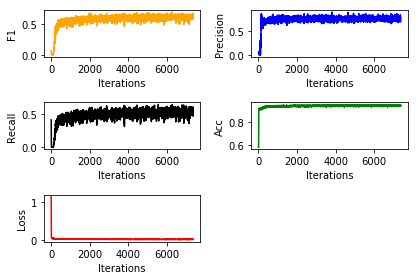

In [10]:
import matplotlib.pyplot as plt
window = 5
iterations = sorted(results.keys())
f1 = pd.Series([results[x]['F1'] for x in iterations]).rolling(window=window).mean()
p = pd.Series([results[x]['P'] for x in iterations]).rolling(window=window).mean()
r = pd.Series([results[x]['R'] for x in iterations]).rolling(window=window).mean()
acc = pd.Series([results[x]['ACC'] for x in iterations]).rolling(window=window).mean()
loss_vals = pd.Series([results[x]['Loss'] for x in iterations]).rolling(window=window).mean()

# plt.plot(year, pop_pakistan, color='g')
rows = 3
cols = 2

plt.subplot(rows, cols, 1)
plt.plot(iterations, f1, color='orange')
plt.xlabel('Iterations')
plt.ylabel('F1')

plt.subplot(rows, cols, 2)
plt.plot(iterations, p, color='blue')
plt.xlabel('Iterations')
plt.ylabel('Precision')

plt.subplot(rows, cols, 3)
plt.plot(iterations, r, color='black')
plt.xlabel('Iterations')
plt.ylabel('Recall')

plt.subplot(rows, cols, 4)
plt.plot(iterations, acc, color='green')
plt.xlabel('Iterations')
plt.ylabel('Acc')

plt.subplot(rows, cols, 5)
plt.plot(iterations, loss_vals, color='red')
plt.xlabel('Iterations')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()